In [228]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Feature Importance
* In this notebook we will compare different feature importance methods, directly comparing results against a single data set. The goal is to see how different methods vary, how they can be used to improve machine learning models, and build tools to evaluate our confidence in the predictive capability of features. 
* The data set is on housing prices, where the target is the sale price of the house. There are 13 variables, some categorical (condition e.g.) and other continuous (resting sqft_lot e.g.)

In [11]:
pd.set_option('display.max_columns', None)

In [13]:
data = pd.read_csv('kc_house_data.csv', parse_dates=['date'])

In [14]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
# Extract year & month
data['year'] = data.date.dt.year

In [18]:
# Drop columns
data.drop(columns=['id','date','zipcode'], inplace=True)

In [19]:
data.shape

(21613, 19)

In [20]:
X = data.drop(columns=['price'])
y = data['price']

In [294]:
%run featimp.py

## Direct From Data Strategies
* This section deals with strategies that compute feature importances directly from the data (i.e. without the need for other components like a machine learning model)
* We evaluate three strategies: Spearman's Rank Correlation Coefficient, Principal Component Analysis (PCA), and Minimal-Redundancy-Maximal-Relevance

### Spearman's Rank Correlation Coefficient
* Measures how well the relationship between two variables can be explained by a monotonic function. That is to say, if for a given x,y point (our two variables) all points x* > x means y* > y as well then our two variables have a Spearman value of 1. This is slightly different than the Pearson Correlation Coefficient, which measures linearity between two variables


In [67]:
rho, pval = spearmanr(X, y)

In [69]:
rho.shape

(19, 19)

In [73]:
rho = pd.DataFrame(rho, index=data.columns, columns=data.columns)

In [76]:
spearman_corrs = rho.loc['price']

Here we see Bathrooms and Grade have the highest values, indicating that as their values increase it is very likely that Price increases as well. A very negative number would have also indicated importance, just in the opposite direction (as predictor increases, price decreases). But all negative importances are very close to zero.

In [78]:
spearman_corrs.sort_values(ascending=False)

price            1.000000
bathrooms        0.647366
grade            0.539704
bedrooms         0.521406
long             0.443816
condition        0.380534
year             0.344652
sqft_above       0.230496
sqft_lot         0.227541
sqft_living      0.216531
sqft_living15    0.201577
lat              0.191389
sqft_basement    0.180022
waterfront       0.081421
yr_built         0.016877
view             0.012660
floors          -0.007598
sqft_lot15      -0.010468
yr_renovated    -0.021185
Name: price, dtype: float64

### Principal Component Analysis (PCA)
* PCA breaks down a high-dimensional data set into k-eigenvectors that explain the most variance in the new k-dimensional space. If the top eigenvectors explain a large portion of the variance, then looking at the contribution of the original X variables to those eigenvectors can give some indication of feature importance

In [204]:
explained_variance_ratio, pca_imps = pca_strategy(X, n_components=4)

It looks like the first component explains most of the variance. Therefore we will look at which X-variables make up the first component

In [205]:
explained_variance_ratio

0    0.883719
1    0.115355
2    0.000684
3    0.000113
dtype: float64

In the first component, all of the sqft variables are the most important

In [206]:
pca_imps

sqft_lot         8.696206e-01
sqft_lot15       4.936884e-01
sqft_living      3.671557e-03
sqft_above       3.511932e-03
sqft_living15    2.419266e-03
sqft_basement    1.596248e-04
yr_renovated     7.038287e-05
yr_built         3.873991e-05
grade            3.080846e-06
bathrooms        1.535677e-06
view             1.292275e-06
long             7.568169e-07
bedrooms         1.642508e-07
waterfront       4.740016e-08
year             4.201824e-08
floors          -8.335986e-08
condition       -1.104119e-07
lat             -2.705592e-07
Name: First Component, dtype: float64

### Minimal-Redundancy-Maximal-Relevance
We now look at a strategy that ranks features not only on their correlation to the target, but also penalizes for having shared information with other predictor variables. The equation is shown below. "I" is any function that has some measure of association between variables. In our case we will use Spearman's Rank

<img src='mRMR.png'>

In [132]:
Jmrmr = mrmr(X,y)

The interesting result here is that sqft_lot is no longer ranked as the most important feature. This is likely due to the fact that it is a variable that is highly correlated with other features. 

In [133]:
Jmrmr

lat              0.416846
grade            0.327330
sqft_living      0.258139
sqft_living15    0.225390
sqft_above       0.190499
bathrooms        0.166463
sqft_basement    0.149397
floors           0.138289
sqft_lot15       0.138153
view             0.136215
sqft_lot         0.126558
long             0.124700
yr_built         0.082037
bedrooms         0.075092
yr_renovated     0.041850
year             0.036067
condition        0.022042
waterfront       0.011724
dtype: float64

## Model-Based Importance Strategies
In these strategies, we use specific machine learning models as a mechanism to evaluate the importance of our features. We examine two strategies: permutation importance and drop-column importance

### Permutation Importance
* In this strategy, we first establish a baseline score by training our model and then evaluating on an un-altered validation set (Note: this strategy can be used for any type of model, but here we are specifically using a Random Forest). Then for every feature we repeat this process: 
<ol>
    <li>Permute (shuffle) the values of the column in the validation set</li>
    <li>On the already trained model, evaluate on the permuted validation set</li>
    <li>Record the change in your evaluation metric from the baseline to the permuted score. Those features with the largest change are most important</li>
</ol>
* The advantage of this method is that you only have to train the model once, and simply evaluate on all the different permuted validation sets

In [152]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1)

In [193]:
baseline_score, importances = permutation_importance(X, y, rf)

In [194]:
print(f"Our baseline score (with no column permutations) is: {baseline_score:0.4f}")

Our baseline score (with no column permutations) is: 0.8781


Below we see our new scores (r-squared in this case) after that variable has been permuted. Those with the biggest drop show high importance. On the other end, the score for "floors" actually went slightly up after being permuted, which means it is no better than noise as a predictive variable in our model

In [195]:
importances

,variable,permuted score,change
13,lat,0.484853,-0.393285
8,grade,0.614202,-0.263936
2,sqft_living,0.635860,-0.242278
14,long,0.699429,-0.178708
11,yr_built,0.846238,-0.031899
15,sqft_living15,0.847876,-0.030262
5,waterfront,0.850536,-0.027601
6,view,0.866191,-0.011947
16,sqft_lot15,0.869579,-0.008559
3,sqft_lot,0.871008,-0.007130


### Drop-Column Importance
* In this strategy, we again first establish a baseline score by training our model on a training set and then evaluating on a validation set. However, this time as we consider the importance of every feature we will be completely dropping it from both the training and validation set. The consequence of this is that we must retrain the model for every feature. This does produce more accurate importances but can become computationally infeasible as the number of features grows large

In [197]:
baseline_score, importances = drop_column_importance(X, y, rf)

In [198]:
print(f"Our baseline score (with no column permutations) is: {baseline_score:0.4f}")

Our baseline score (with no column permutations) is: 0.8765


Again, we see similar variables at the top of the list compared to permuation importances. These values are more accurate as we have completely retrained the model, ignoring the dropped column, however it comes at the added expense of retraining many times.

In [199]:
importances

,variable,drop score,change
13,lat,0.783356,-0.093185
14,long,0.840746,-0.035796
2,sqft_living,0.857800,-0.018741
8,grade,0.865408,-0.011133
5,waterfront,0.865585,-0.010956
6,view,0.869628,-0.006913
15,sqft_living15,0.873786,-0.002755
9,sqft_above,0.874155,-0.002386
16,sqft_lot15,0.874462,-0.002079
17,year,0.876318,-0.000223


## Comparing Strategies
Now that we have several ways of computing feature importances, we can compare strategies. Our approach will be to keep the top feature from each approach and train a model, computing a cross-validation score for each. Then repeat the process for the top 2, 3, ..., k features in each strategy. The result will allow us to see how cross-validation scores change as we keep more features in each strategy

In [224]:
strategy_results = compare_strategies(X, y, rf, k=8)

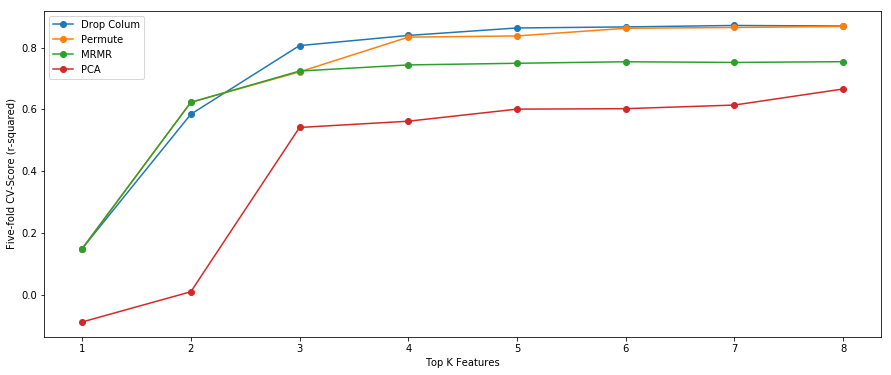

In [233]:
plt.figure(figsize=(15,6))
plt.plot('Number of Columns', 'CV Score', label='Drop Colum', marker='o',
         data=strategy_results.loc[strategy_results.Strategy=='Drop Column'])
plt.plot('Number of Columns', 'CV Score', label='Permute', marker='o',
         data=strategy_results.loc[strategy_results.Strategy=='Permute'])
plt.plot('Number of Columns', 'CV Score', label='MRMR', marker='o',
         data=strategy_results.loc[strategy_results.Strategy=='MRMR'])
plt.plot('Number of Columns', 'CV Score', label='PCA', marker='o',
         data=strategy_results.loc[strategy_results.Strategy=='PCA'])
plt.legend()
plt.ylabel('Five-fold CV-Score (r-squared)')
plt.xlabel('Top K Features')
plt.show()

From the above plot it seems like Drop-Column and Permute importances do the best job at finding important features. By far the poorest ranking initially is that from PCA. We can also compare how the ranked features compare in a different model like Linear Regression

In [229]:
lr = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)

In [230]:
lr_strategy_results = compare_strategies(X, y, lr, k=8)

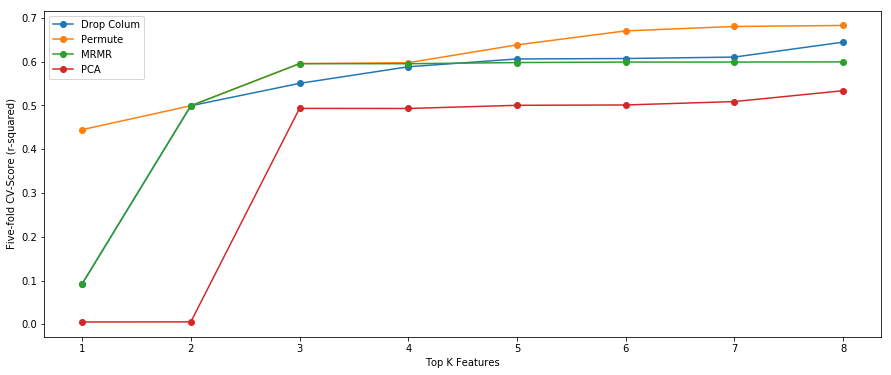

In [235]:
plt.figure(figsize=(15,6))
plt.plot('Number of Columns', 'CV Score', label='Drop Colum', marker='o',
         data=lr_strategy_results.loc[lr_strategy_results.Strategy=='Drop Column'])
plt.plot('Number of Columns', 'CV Score', label='Permute', marker='o',
         data=lr_strategy_results.loc[lr_strategy_results.Strategy=='Permute'])
plt.plot('Number of Columns', 'CV Score', label='MRMR', marker='o',
         data=lr_strategy_results.loc[lr_strategy_results.Strategy=='MRMR'])
plt.plot('Number of Columns', 'CV Score', label='PCA', marker='o',
         data=lr_strategy_results.loc[lr_strategy_results.Strategy=='PCA'])
plt.legend()
plt.ylabel('Five-fold CV-Score (r-squared)')
plt.xlabel('Top K Features')
plt.show()

Interestingly, for linear regression from the start Permute importance does better than other methods. Also Drop Column importance and MRMR are closer. But as before, PCA peforms the worst

## Automatic Feature Selection
Given that we now have several strategies for ranking features, we can apply them towards automatically selecting the best set of features for a given model. 
<ol>
    <li>Start by evaluating the model (compute a cross-validation score e.g.) with all of the features and compute the feature importances.</li>
    <li>Drop the lowest ranked feature and recompute the validation score.</li>
    <li>If the validation score improves, recalculate the feature rankings on our new subset of features and again drop the new lowest ranked feature.</li>
    <li>Continue this process until the validation score doesn't improve.</li>
</ol>
Note: we have to recompute feature rankings at each iteration as some features may have co-dependencies

In [269]:
remaining_features, automatic_results = automatic_feature_selection(X, y, rf, permutation_importance)

Here we automatically selected features for a Random Forest model using permuation importance as our ranking. We can see that only one feature was dropped (bedrooms) before the CV score failed to increase. This is perhaps expected as Random Forest are not as prone to overfitting, even in the presence of unimportant features. Next we will try the same procedure but with a Linear Regression model

In [271]:
automatic_results

,CV Score,Feature Dropped
0,0.868516,
1,0.871475,bedrooms


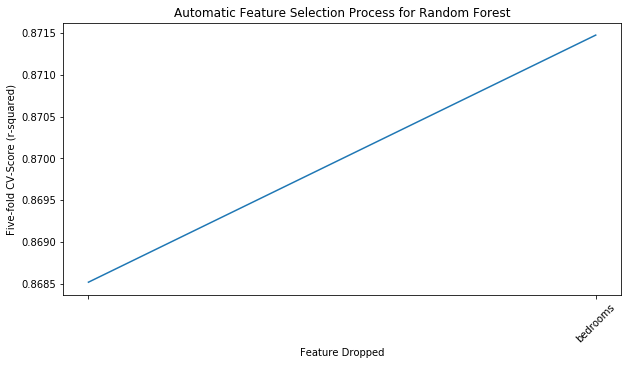

In [326]:
plt.figure(figsize=(10,5))
plt.plot('Feature Dropped', 'CV Score', data=automatic_results)
plt.ylabel('Five-fold CV-Score (r-squared)')
plt.xlabel('Feature Dropped')
plt.title('Automatic Feature Selection Process for Random Forest')
plt.xticks(rotation=45)
plt.show()

In [285]:
print(f"Remaining features: {remaining_features.str.cat(sep=', ')}")

Remaining features: lat, grade, sqft_living, long, sqft_living15, yr_built, waterfront, view, sqft_lot15, sqft_above, sqft_lot, year, condition, yr_renovated, bathrooms, floors, sqft_basement


In [276]:
lr_remaining_features, lr_automatic_results = automatic_feature_selection(X, y, lr, permutation_importance)

In [277]:
lr_automatic_results

,CV Score,Feature Dropped
0,0.687253,
1,0.687317,bedrooms
2,0.687461,floors


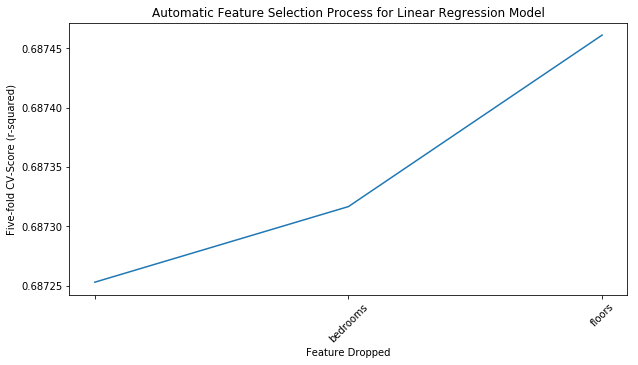

In [327]:
plt.figure(figsize=(10,5))
plt.plot('Feature Dropped', 'CV Score', data=lr_automatic_results)
plt.ylabel('Five-fold CV-Score (r-squared)')
plt.xlabel('Feature Dropped')
plt.title('Automatic Feature Selection Process for Linear Regression Model')
plt.xticks(rotation=45)
plt.show()

Again, we drop very few features (only bedrooms and floors) before the CV score fails to increase.

In [286]:
print(f"Remaining features: {lr_remaining_features.str.cat(sep=', ')}")

Remaining features: grade, lat, sqft_living, sqft_above, yr_built, waterfront, view, bathrooms, sqft_basement, sqft_living15, year, condition, long, sqft_lot15, yr_renovated, sqft_lot


## Variance in Feature Importances
By bootstrapping we are able to get several measurements of feature importance for each variable, and thereby also get an approximation of the standard deviation of those measurements

In [300]:
averaged_importances = bootstrapped_importances(X, y, rf, permutation_importance, iterations=20)

In [308]:
averaged_importances['change mean'] = np.abs(averaged_importances['change mean'])
averaged_importances = averaged_importances.sort_values('change mean', ascending=False).reset_index(drop=True)

In [309]:
averaged_importances

,variable,change mean,change std
0,lat,0.386146,0.026450
1,sqft_living,0.340003,0.094310
2,grade,0.214291,0.071565
3,long,0.187671,0.022110
4,sqft_living15,0.043412,0.007278
5,yr_built,0.042792,0.027150
6,waterfront,0.028575,0.007112
7,sqft_above,0.014111,0.004263
8,view,0.013469,0.003817
9,sqft_lot,0.009992,0.001696


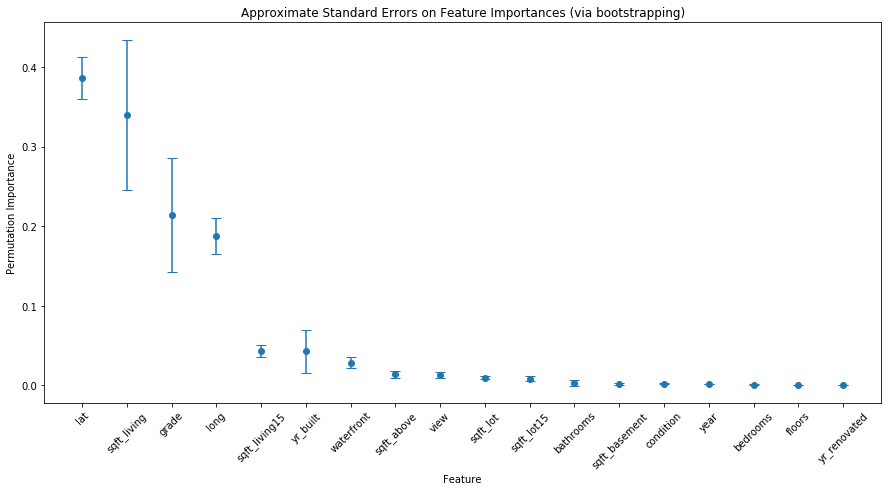

In [315]:
plt.figure(figsize=(15,7))
plt.errorbar('variable', 'change mean', yerr='change std', data=averaged_importances,
             marker='o', linestyle='', capsize=5)
plt.xticks(rotation=45)
plt.ylabel('Permutation Importance')
plt.xlabel('Feature')
plt.title('Approximate Standard Errors on Feature Importances (via bootstrapping)')
plt.show()